In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import xarray as xr 
import datetime 
import pytz
import csv
import seaborn as sns
from scipy.stats import kde
from scipy.stats import gaussian_kde
from haversine import haversine
import netCDF4
import xskillscore as xs
import geopandas as gpd
from scipy import stats
import rioxarray 
import matplotlib.pyplot as plt

#External functions 
import fct.storm_eu_cluster as storm_eu_cluster
from fct.paths import *

KeyboardInterrupt: 

In [ ]:
########### IMPORT STORMS
period = "1979-2024WIN"

df_info_storm                                  = {}
df_storm                                       = {}
cat_type                                       = ['FR_ALL_24h']

#Tracks lasting more than 24h
df_info_storm['FR_ALL_24h_original']                       = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['FR_ALL_24h_original']['storm_landing_date'] = pd.to_datetime(df_info_storm['FR_ALL_24h_original']['storm_landing_date'])
df_storm['FR_ALL_24h_original']                            = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+".csv", encoding='utf-8')

# Import de the Europe shapefile 
FRA_geo_shp = gpd.read_file(os.path.join(PATH_SHP_COUNTRIES, "world-administrative-boundaries_FRA_level0.shp"))

########## IMPACT DATA 
window        = "d-3_d+3"
min_claims_range = [50]
method        = 'wgust'
year_start    = 1997
year_end      = 2024
version_date  = "v050126"
sinclim_version = 2.1 #2.1 # 2.2
sinclim_peril   = "storm" # "storm_extended" # "storm"

In [ ]:
########## CLUSTER 
cluster_window = [72, 96, 120]
radius = np.arange(700, 1300, 100)#[700]
df_mult_cluster = {}
df_info_mult_cluster = {}

# for r_sinclim, r_varying in zip([900, 1100, 1300, 1300], [False, False, False, True]) : 
for r_sinclim, r_varying in zip([1300], [False]) : 
    for min_claim in min_claims_range : 
        if r_varying : 
#             fname_in = f"sinclim_v{sinclim_version}_{sinclim_peril}_{window}_unique-{method}_min{min_claim}_priestley_ALL_{year_start}-{year_end}_r-varying_{version_date}"
            fname_in = f"sinclim_v{sinclim_version}_{sinclim_peril}_{window}_unique-{method}_min{min_claim}_priestley_ALL_{year_start}-{year_end}_r-varying"
            sinclim       = pd.read_csv(PATH_GENERALI+fname_in+".csv", low_memory=False, dtype={'cod_sin': str, "cod_pol" : str})
#             sinclim       = pd.read_parquet(PATH_GENERALI+fname_in+".parquet")
        else : 
            fname_in = f"sinclim_v{sinclim_version}_{sinclim_peril}_{window}_unique-{method}_min{min_claim}_priestley_ALL_{year_start}-{year_end}_r{r_sinclim}_{version_date}"
            fname_in = f"sinclim_v{sinclim_version}_{sinclim_peril}_{window}_unique-{method}_min{min_claim}_priestley_ALL_{year_start}-{year_end}_r{r_sinclim}"
            sinclim       = pd.read_csv(PATH_GENERALI+fname_in+".csv", low_memory=False, dtype={'cod_sin': str, "cod_pol" : str})
#             sinclim       = pd.read_parquet(PATH_GENERALI+fname_in+".parquet")
            
        stromi_impact = sinclim.storm_id.unique()

        df_info_storm['FR_ALL_24h'] = df_info_storm['FR_ALL_24h_original'].loc[df_info_storm['FR_ALL_24h_original'].storm_id.isin(stromi_impact)]
        df_storm['FR_ALL_24h']      = df_storm['FR_ALL_24h_original'].loc[df_storm['FR_ALL_24h_original'].storm_id.isin(stromi_impact)]
        for nb_hours in cluster_window : 
            for r in radius : 
                df_cluster = {}
                df_info_cluster = {}

                for cat in cat_type : 

                    #### RUN FOR STORM IN MULTIPLE CLUSTERS 
                    df_info_cluster = storm_eu_cluster.assign_clusters_allow_multiple(df_info_storm[cat], df_storm[cat], r=r, nb_hours_diff=nb_hours)
                    df_info_mult_cluster[r] = storm_eu_cluster.filter_clusters_explode(df_info_cluster)
                    df_mult_cluster[r] = df_storm[cat].loc[df_storm[cat].storm_id.isin(df_info_mult_cluster[r].storm_id.unique())]

#                     if r_varying : 
#                         fname_storm_out = f"tracks_{cat}_impact_v{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_r-varying_{version_date}_clust-mult-2storms-{nb_hours}h_r{r}_{period}"
#                         df_mult_cluster.to_csv(PATH_TRACKS+fname_storm_out+".csv", 
#                                                encoding='utf-8', index=False) 
#                         df_info_mult_cluster.to_csv(PATH_TRACKS+fname_storm_out+"_info.csv", 
#                                                     encoding='utf-8', index=False)
#                     else : 
#                         fname_storm_out = f"tracks_{cat}_impact_v{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_r{r_sinclim}_{version_date}_clust-mult-2storms-{nb_hours}h_r{r}_{period}"
#                         df_mult_cluster.to_csv(PATH_TRACKS+fname_storm_out+".csv", 
#                                                encoding='utf-8', index=False) 
#                         df_info_mult_cluster.to_csv(PATH_TRACKS+fname_storm_out+"_info.csv", 
#                                                     encoding='utf-8', index=False)
#                         df_mult_cluster.to_csv(PATH_TRACKS+f"tracks_{cat}_impact_{window}unique-{method}_min{min_claim}_r{r_sinclim}_clust-mult-2storms-{nb_hours}h_r{r}_{period}.csv", 
#                                                encoding='utf-8', index=False) 
#                         df_info_mult_cluster.to_csv(PATH_TRACKS+f"tracks_{cat}_impact_{window}unique-{method}_min{min_claim}_r{r_sinclim}_clust-mult-2storms-{nb_hours}h_r{r}_{period}_info.csv", 
#                                                     encoding='utf-8', index=False)


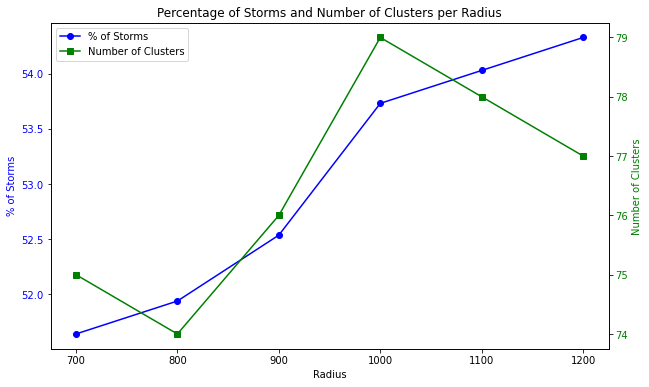

In [48]:
# Prepare lists to store metrics
# Total number of storms in sinclim
total_storms = sinclim['storm_id'].nunique()

# Prepare lists to store metrics
radii = []
perc_storms = []
num_clusters = []

for radius, df in df_info_mult_cluster.items():
    radii.append(radius)
    
    # % of unique storms
    perc_storms.append(df['storm_id'].nunique() / total_storms * 100)
    
    # Number of unique clusters
    num_clusters.append(df['clust_id'].nunique())

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'radius': radii,
    '%_storms': perc_storms,
    'num_clusters': num_clusters
}).sort_values('radius')

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: % of storms
ax1.plot(summary_df['radius'], summary_df['%_storms'], marker='o', color='blue', label='% of Storms')
ax1.set_xlabel('Radius')
ax1.set_ylabel('% of Storms', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right y-axis: number of clusters
ax2 = ax1.twinx()
ax2.plot(summary_df['radius'], summary_df['num_clusters'], marker='s', color='green', label='Number of Clusters')
ax2.set_ylabel('Number of Clusters', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Percentage of Storms and Number of Clusters per Radius')
plt.show()

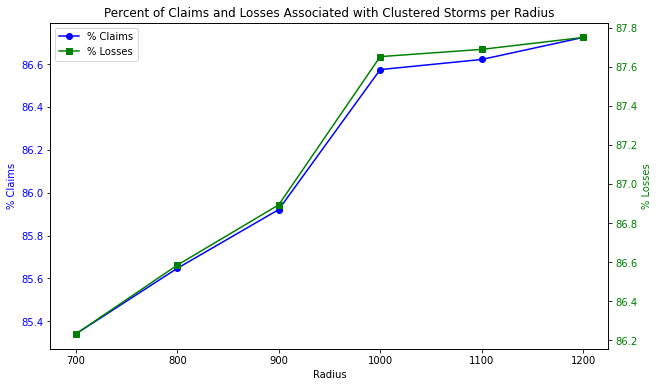

In [47]:
# Prepare lists
radii = []
perc_claims_clustered = []
perc_losses_clustered = []

total_claims = len(sinclim)
total_losses = sinclim['num_chg_brut'].sum()

for radius, df_clusters in df_info_mult_cluster.items():
    clustered_storms = df_clusters['storm_id'].unique()
    
    # Filter claims for clustered storms
    clustered_claims = sinclim[sinclim['storm_id'].isin(clustered_storms)]
    
    # % of claims and losses
    perc_claims = len(clustered_claims) / total_claims * 100
    perc_losses = clustered_claims['num_chg_brut'].sum() / total_losses * 100
    
    # Store
    radii.append(radius)
    perc_claims_clustered.append(perc_claims)
    perc_losses_clustered.append(perc_losses)

# Create DataFrame for plotting
summary_df = pd.DataFrame({
    'radius': radii,
    '%claims': perc_claims_clustered,
    '%losses': perc_losses_clustered
}).sort_values('radius')

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: % claims
ax1.plot(summary_df['radius'], summary_df['%claims'], marker='o', color='blue', label='% Claims')
ax1.set_xlabel('Radius')
ax1.set_ylabel('% Claims', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right y-axis: % losses
ax2 = ax1.twinx()
ax2.plot(summary_df['radius'], summary_df['%losses'], marker='s', color='green', label='% Losses')
ax2.set_ylabel('% Losses', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Percent of Claims and Losses Associated with Clustered Storms per Radius')
plt.show()